In [1]:
!pip install --upgrade albumentations
!pip install --upgrade torch_lr_finder
!nvidia-smi

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (1.0.3)
Requirement already up-to-date: torch_lr_finder in /usr/local/lib/python3.7/dist-packages (0.2.1)
Mon Jul 19 08:29:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                    

In [2]:
import torch
import torchvision
import cv2
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from functools import partial
import time
%matplotlib inline

conv = partial(nn.Conv2d, bias=False)
bn = nn.BatchNorm2d
relu = nn.ReLU

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2, ToTensor

torch.backends.cudnn.benchmark = True

In [4]:
transform = transforms.Compose([transforms.ToTensor()]) # simple ToTensor for now

train_set = torchvision.datasets.CIFAR10(root='./cifar10', download=True, train=True, transform=transform)


Files already downloaded and verified


In [5]:
train_set.data.shape # train data shape

(50000, 32, 32, 3)

In [6]:
# calculate mean and standard deviation

mean = np.mean(train_set.data, axis=(0,1,2))


sdev = np.std(train_set.data, axis=(0, 1, 2))


In [7]:
mean = mean/255
sdev = sdev/255

In [8]:
SEED = 101
BATCH = 512

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

if cuda:
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")

# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=BATCH, num_workers=2, pin_memory=True)\
    if cuda else dict(shuffle=True, batch_size=32)


CUDA Available? True


In [9]:
# dataset= dsets.CIFAR10(root='./cifar10/data/', transform=transform, train= True, download=True)
# test_set= dsets.CIFAR10(root="./cifar10/data/", transform=transform, train= False)

def ZCA_whitening(X):
    X= X.reshape((-1, np.product(X.shape[1:])))
    X_centered= X - np.mean(X, axis= 0)
    Sigma= np.dot(X_centered.T, X_centered) / X_centered.shape[0]
    U, Lambda, _= np.linalg.svd(Sigma)
    W= np.dot(U, np.dot(np.diag(1.0/np.sqrt(Lambda + 1e-5)), U.T))
    
    X_ZCA= np.dot(X_centered, W.T)
    X_ZCA_rescaled = (X_ZCA - X_ZCA.min()) / (X_ZCA.max() - X_ZCA.min())
    return X_ZCA_rescaled

# dataset_zca= ZCA_whitening(dataset.train_data)
# test_set_zca= ZCA_whitening(test_set.test_data)

# dataset_zca= torch.tensor(dataset_zca.reshape(-1,32,32,3))
# test_set_zca= torch.tensor(test_set_zca.reshape(-1,32,32,3))

# torch.Tensor(dataset.train_data)
# torch.Tensor(test_set.test_data)

In [10]:
# class GaussNoise():
#     def __init__(self, mean , sdev):
#         self.mean = mean
#         self.sdev = sdev
    
#     def __call__(self, tensor=None, size=None):
#         if tensor:
#             val= torch.rand(tensor.size(), dtype=tensor.dtype) * self.sdev + self.mean

#             return val
#         else:
#             return np.random.rand(size) * self.sdev + self.mean

In [11]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [12]:
# noise = GaussNoise(mean=mean, sdev=sdev)
# noise_to_add = noise(size=mean.shape[0])
lr_epochs = []
# noise(size=1)[0], noise_to_add

In [13]:
def apply_ricap(*, batch, beta=0.3):

    input, target = batch

    I_x, I_y = input.size()[2:]

    w = int(np.round(I_x * np.random.beta(beta, beta)))
    h = int(np.round(I_y * np.random.beta(beta, beta)))
    w_ = [w, I_x - w, w, I_x - w]
    h_ = [h, h, I_y - h, I_y - h]

    cropped_images = {}
    c_ = {}
    W_ = {}

    for k in range(4):
        idx = torch.randperm(input.size(0))
        x_k = np.random.randint(0, I_x - w_[k] + 1)
        y_k = np.random.randint(0, I_y - h_[k] + 1)
        cropped_images[k] = input[idx][:, :, x_k:x_k + w_[k], y_k:y_k + h_[k]]
        c_[k] = target[idx].cuda()
        W_[k] = w_[k] * h_[k] / (I_x * I_y)

    patched_images = torch.cat(
        (torch.cat((cropped_images[0], cropped_images[1]), 2),
         torch.cat((cropped_images[2], cropped_images[3]), 2)),
        3)

    patched_images = patched_images.cuda()
    
    return patched_images

In [30]:
def train_eval_model(model, train_loader, optimizer, device, epochs=1,
                     criterion=None,
                     test=False, test_loader=None,
                     scheduler=None,
                     grad_clip=None,
                     l1=False, lambda_1=0.001,
                     noise_level=0.1,
                     ricap_apply=False,
                     ricap_beta=0.3,
                     ricap_prob=0.1):
    if not model:
        raise NotImplementedError("\nNo model provided")
    if not train_loader:
        raise NotImplementedError("\nTrain Loader not provided")
    if not optimizer:
        raise NotImplementedError("\nOptimizer not provided")
    if not device:
        raise ValueError("\nno device provided, kindly provide CPU or Cuda to use")
    if ricap_apply:
        print(f"\n\nRICAP has been set to True with probability: {ricap_prob} and Beta value: {ricap_beta}")
    
    # if `criterion` is not given use CrossEntropy Loss as default
    if not criterion:
        criterion = nn.CrossEntropyLoss()
    
    model.train()  # set the train mode

    scaler = torch.cuda.amp.GradScaler()  # create grad scaler
    
    # iterate over for `epochs` epochs and keep storing valuable info
    for epoch in range(epochs):
        print(f"\n\n\nepoch num ===================================== {epoch + 1}")
        correct = processed = train_loss = regularization_loss = 0

        pbar = tqdm(train_loader)
        ricap_count = 0

        if scheduler:
            last_lr = scheduler.get_last_lr()
            lr_epochs.append((epoch + 1, last_lr))
            print(f"LR at epoch {epoch + 1} start: -->", last_lr, end="\n\n")

        if l1:
            for param in model.parameters():
                regularization_loss += torch.sum(abs(param))

        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)  # move data to `device`

            optimizer.zero_grad()  # zero out the gradients to avoid accumulating them over loops

            # apply RICAP is flag is True and `ricap_prob` greater than random number
            if ricap_apply and (ricap_prob > np.random.random()):
                # print(f"Applying RICAP")
                ricap_count += 1
                data = apply_ricap(batch=(data, target), beta=ricap_beta)

            with torch.cuda.amp.autocast():
              output = model(data)  # get model's predictions
              
              loss = criterion(output, target) + lambda_1 * regularization_loss
            #   loss += noise(tensor=loss)

            train_loss += loss.item()

            scaler.scale(loss).backward()
            # loss.backward() # to perform backpropagation and calculate the gradients

            # if gradient clipping is to be used
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            # optimizer.step() # take 1 step for the optimizer and update the weights

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

            correct += pred.eq(target.view_as(
                pred)).sum().item()  # compare and see how many predictions are coorect and then add up the count

            processed += len(data)  # total processed data size

            scaler.step(optimizer)
            scaler.update()

            if scheduler:
                scheduler.step()

        acc = 100 * correct / processed

        train_losses.append(train_loss)

        train_accuracy.append(acc)

        pbar.set_description(desc=f'loss={loss.item()} batch_id={batch_idx}')

        total_batch_iters = len(train_loader)
        ricap_perc = ricap_count/total_batch_iters
        print(f"\n\nRicap applied: {ricap_perc * 100:.2f} percent of total batch iterations")

        train_loss /= len(train_loader.dataset)
        print('\n\t\t\tTrain metrics: accuracy: {}/{} ({:.4f}%)'.format(correct, len(train_loader.dataset),
                                                                        correct * 100 / len(train_loader.dataset)))

        if test:  # moving to evaluation
            model.eval()  # set the correct mode
            correct = test_loss = 0

            with torch.no_grad():  # to disable gradient calculation with no_grad context
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)

                    output = model(data)

                    test_loss += criterion(output, target).sum().item()  # sum up batch loss

                    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

                    correct += pred.eq(target.view_as(pred)).sum().item()

            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
            test_accuracy.append(100. * correct / len(test_loader.dataset))

            print('\n\tTest metrics: average loss: {:.4f}, accuracy: {}/{} ({:.5f}%)\n'.format(
                test_loss, correct, len(test_loader.dataset),
                100. * correct / len(test_loader.dataset)))


In [31]:
def plot_graphs(*, train_losses, train_accuracy, test_losses, test_accuracy):
    fig, axs = plt.subplots(2,2,figsize=(20,10))
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_accuracy)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_accuracy)
    axs[1, 1].set_title("Test Accuracy")

In [32]:
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="./data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [34]:
# # transforms

# train_transforms = A.Compose([
#                             A.augmentations.transforms.PadIfNeeded(min_height=40, min_width=40, border_mode=cv2.BORDER_CONSTANT,
#                                                                        p=0.5,value=mean),
#                             A.RandomCrop(32, 32, p=1),
#                             A.HorizontalFlip(p=0.5),
#                             A.CoarseDropout(max_holes=1,
#                                             p=0.2,
#                                             max_height=8,
#                                             max_width=8,
#                                             min_height=8,
#                                             min_width=8,
#                                             fill_value= mean),
                              
#                             A.Normalize(mean=mean, std=sdev),
#                             ToTensor()
#                             ])

# test_transforms = A.Compose([A.HorizontalFlip(p=0.3),
#                              A.Normalize(mean=mean, std=sdev),
#                             ToTensor()
#                             ])


train_transforms = A.Compose([     
                    A.Sequential([
                    A.CropAndPad(px=4, keep_size=False),
                    A.RandomCrop(32,32)]),
                    A.HorizontalFlip(p=0.3),
                    A.CoarseDropout(p=0.2, max_holes = 1, max_height=8, max_width=8, min_height=8,
                                    min_width=8, fill_value=(0.4914, 0.4822, 0.4465)),
                    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
                    ToTensorV2(),
                    ])

test_transforms = A.Compose([
                  A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
                  ToTensorV2(),
                ])

In [35]:

# data sets with transforms
train_set = Cifar10SearchDataset(train=True, download=True, transform=train_transforms)

test_set = Cifar10SearchDataset(train=False, download=True, transform=test_transforms)


# data loaders on data sets
train_loader = torch.utils.data.DataLoader(dataset=train_set, **dataloader_args)

test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 3, 32, 32])
torch.Size([512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

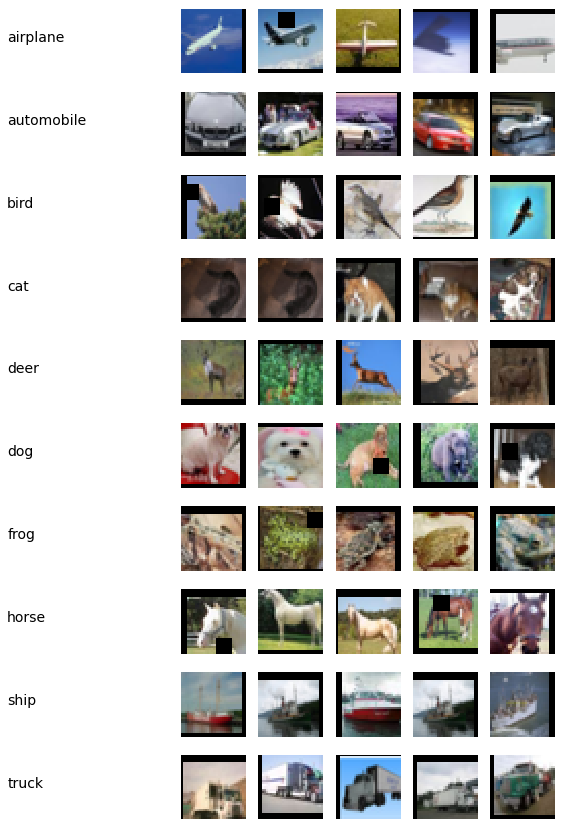

In [36]:
from __future__ import print_function
# channel_means = (0.49196659, 0.48229005, 0.4461573)
# channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*sdev[i])+mean[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [37]:
class GBN(torch.nn.Module):
    """
    Ghost Batch Normalization
    """

    def __init__(self, input_dim, virtual_batch_size=128, momentum=0.01):
        super(GBN, self).__init__()

        self.input_dim = input_dim
        self.virtual_batch_size = virtual_batch_size
        self.bn = nn.BatchNorm2d(self.input_dim, momentum=momentum)

    def forward(self, x):
        chunks = x.chunk(int(np.ceil(x.shape[0] / self.virtual_batch_size)), 0)
        res = [self.bn(x_) for x_ in chunks]

        return torch.cat(res, dim=0)

In [38]:
# def get_conv_block(in_channels=3, out_channels=64, max_pool=False):
#     layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)]
    
#     if max_pool:
#         layers.append(nn.MaxPool2d(2))

#     layers.extend([nn.BatchNorm2d(out_channels, momentum=0.9),
#                    nn.ReLU(inplace=True)])

#     return nn.Sequential(*layers)

"""Pre-activated approach, try with this now"""
def get_conv_block(in_channels=3, out_channels=64, max_pool=False):
    layers = [nn.BatchNorm2d(in_channels, momentum=0.9),
                   nn.ReLU(inplace=True)]
    
    if max_pool:
        layers.append(nn.MaxPool2d(2))

    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False))

    return nn.Sequential(*layers)

class CustomResNet(nn.Module):
    def __init__(self, in_planes, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
        self.conv1 = get_conv_block(in_channels = in_planes, out_channels = 64)

        self.conv2 = get_conv_block(in_channels = 64, out_channels = 128, max_pool=True)

        self.res1 = nn.Sequential(get_conv_block(in_channels=128, out_channels=128), get_conv_block(in_channels=128, out_channels=128))
        
        self.conv3 = get_conv_block(128, 256, max_pool=True)

        self.conv4 = get_conv_block(256, 512, max_pool=True)
        
        self.res2 = nn.Sequential(get_conv_block(512, 512), get_conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes, bias=False))
        # self.extra_1 = nn.Sequential(
        #     nn.Conv2d(64, 128, 1, stride=2),
        #     nn.BatchNorm2d(128),
        #     nn.ReLU(),
        #     nn.Conv2d(128, 256, 3, stride=1, padding=1),
        #     nn.BatchNorm2d(256),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2)
        # )
        
    def forward(self, x):
        x1 = out = self.conv1(x)
        out = self.conv2(out)
        out = out + self.res1(out)
        out = self.conv3(out) #+ self.extra_1(x1)
        out = self.conv4(out)
        out = out + self.res2(out)
        out = self.classifier(out)
        # out = out.view(-1, self.num_classes)
        # out = F.softmax(out, dim=-1)
        return out

In [39]:
model = CustomResNet(3, 10).to(device)

criterion = LabelSmoothingLoss(classes=10, smoothing=0.1)
# criterion = nn.CrossEntropyLoss()

summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
              ReLU-2            [-1, 3, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]           1,728
       BatchNorm2d-4           [-1, 64, 32, 32]             128
              ReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,728
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]         147,456
      BatchNorm2d-14          [-1, 128,

In [40]:
# from torch_lr_finder import LRFinder

# # optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
# optimizer = optim.SGD(model.parameters(), lr = 1e-4, momentum=0.9, nesterov=True, weight_decay=1e-5)
# lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
# lr_finder.range_test(train_loader, end_lr=1, num_iter=200)
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

In [41]:
model = CustomResNet(3, 10).to(device)
# 0.02 with decay 1e-5 -> seems promising & 0.05 with 2e-5

max_lr = 2.6e-2
# 0.05, -> 
# 1) 2.49e-1, -> can take more 2) 2.91e-1 3) 3.1e-1,-> 84% & 82% can take more 4) 4.3e-1 -> can take more perhaps, try
# 5) 4.9e-1,  6) 5.9e-1 with opt lr 2.49e-2, 7) 5.1e-1 with 1.49e-2

optimizer = optim.SGD(model.parameters(), momentum=0.9, lr = max_lr/10, nesterov=True, weight_decay=0.00025) # ["0.000125", "0.00025", "0.0005"]
# 2.49e-2, -> 3.4e-2, 

# optimizer = optim.Adam(model.parameters(), lr=max_lr, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer,
                                                max_lr=max_lr,
                                                pct_start=0.35,
                                                anneal_strategy='linear',
                                                verbose=False,
                                                epochs=24,
                                                cycle_momentum=False,
                                                steps_per_epoch=len(train_loader))



train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
lr_epochs = []

start = time.perf_counter()

train_eval_model(model=model,
                 train_loader=train_loader,
                 optimizer = optimizer,
                 criterion=criterion,
                 device=device,
                 epochs=24,
                 test=True,
                 test_loader=test_loader,
                 scheduler=scheduler,
                 grad_clip=None,
                 noise_level=0)
                # ricap_apply=False,
                #  ricap_prob=0.05,
                #  ricap_beta=0.32)

end = time.perf_counter()

print(f"\n\nTime taken: {(end - start)//60} minutes and {int((end - start)%60)} seconds")

  0%|          | 0/98 [00:00<?, ?it/s]




epoch num ===================================== 1
LR at epoch 1 start: --> [0.00104]



100%|██████████| 98/98 [00:08<00:00, 11.43it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 17453/50000 (34.9060%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0033, accuracy: 4904/10000 (49.04000%)




epoch num ===================================== 2
LR at epoch 2 start: --> [0.004015042568718073]



100%|██████████| 98/98 [00:08<00:00, 11.36it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 14037/50000 (28.0740%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0037, accuracy: 3647/10000 (36.47000%)




epoch num ===================================== 3
LR at epoch 3 start: --> [0.006990085137436148]



100%|██████████| 98/98 [00:08<00:00, 11.81it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 20482/50000 (40.9640%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0032, accuracy: 4995/10000 (49.95000%)




epoch num ===================================== 4
LR at epoch 4 start: --> [0.009965127706154221]



100%|██████████| 98/98 [00:08<00:00, 12.01it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 24511/50000 (49.0220%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0030, accuracy: 5529/10000 (55.29000%)




epoch num ===================================== 5
LR at epoch 5 start: --> [0.012940170274872294]



100%|██████████| 98/98 [00:08<00:00, 11.93it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 27027/50000 (54.0540%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0031, accuracy: 5497/10000 (54.97000%)




epoch num ===================================== 6
LR at epoch 6 start: --> [0.01591521284359037]



100%|██████████| 98/98 [00:08<00:00, 12.04it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 29600/50000 (59.2000%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0028, accuracy: 6247/10000 (62.47000%)




epoch num ===================================== 7
LR at epoch 7 start: --> [0.018890255412308442]



100%|██████████| 98/98 [00:08<00:00, 11.84it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 31853/50000 (63.7060%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0025, accuracy: 6827/10000 (68.27000%)




epoch num ===================================== 8
LR at epoch 8 start: --> [0.021865297981026516]



100%|██████████| 98/98 [00:08<00:00, 11.30it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 33810/50000 (67.6200%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0025, accuracy: 6968/10000 (69.68000%)




epoch num ===================================== 9
LR at epoch 9 start: --> [0.02484034054974459]



100%|██████████| 98/98 [00:08<00:00, 11.21it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 35190/50000 (70.3800%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0023, accuracy: 7396/10000 (73.96000%)




epoch num ===================================== 10
LR at epoch 10 start: --> [0.02498299726530612]



100%|██████████| 98/98 [00:08<00:00, 11.59it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 37587/50000 (75.1740%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0021, accuracy: 7807/10000 (78.07000%)




epoch num ===================================== 11
LR at epoch 11 start: --> [0.02331633726530612]



100%|██████████| 98/98 [00:08<00:00, 11.83it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 38908/50000 (77.8160%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0021, accuracy: 7867/10000 (78.67000%)




epoch num ===================================== 12
LR at epoch 12 start: --> [0.02164967726530612]



100%|██████████| 98/98 [00:08<00:00, 11.84it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 39993/50000 (79.9860%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0020, accuracy: 8080/10000 (80.80000%)




epoch num ===================================== 13
LR at epoch 13 start: --> [0.019983017265306123]



100%|██████████| 98/98 [00:08<00:00, 11.86it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 40969/50000 (81.9380%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0021, accuracy: 7930/10000 (79.30000%)




epoch num ===================================== 14
LR at epoch 14 start: --> [0.018316357265306123]



100%|██████████| 98/98 [00:08<00:00, 12.15it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 41662/50000 (83.3240%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0020, accuracy: 8162/10000 (81.62000%)




epoch num ===================================== 15
LR at epoch 15 start: --> [0.016649697265306122]



100%|██████████| 98/98 [00:08<00:00, 11.27it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 42278/50000 (84.5560%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8213/10000 (82.13000%)




epoch num ===================================== 16
LR at epoch 16 start: --> [0.014983037265306122]



100%|██████████| 98/98 [00:08<00:00, 11.11it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 42917/50000 (85.8340%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8340/10000 (83.40000%)




epoch num ===================================== 17
LR at epoch 17 start: --> [0.013316377265306122]



100%|██████████| 98/98 [00:08<00:00, 11.32it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 43494/50000 (86.9880%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8420/10000 (84.20000%)




epoch num ===================================== 18
LR at epoch 18 start: --> [0.011649717265306125]



100%|██████████| 98/98 [00:08<00:00, 11.83it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 44033/50000 (88.0660%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0018, accuracy: 8459/10000 (84.59000%)




epoch num ===================================== 19
LR at epoch 19 start: --> [0.009983057265306124]



100%|██████████| 98/98 [00:08<00:00, 11.91it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 44314/50000 (88.6280%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0018, accuracy: 8473/10000 (84.73000%)




epoch num ===================================== 20
LR at epoch 20 start: --> [0.00831639726530612]



100%|██████████| 98/98 [00:08<00:00, 12.12it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 44791/50000 (89.5820%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0018, accuracy: 8526/10000 (85.26000%)




epoch num ===================================== 21
LR at epoch 21 start: --> [0.00664973726530612]



100%|██████████| 98/98 [00:08<00:00, 12.01it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 45102/50000 (90.2040%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0018, accuracy: 8598/10000 (85.98000%)




epoch num ===================================== 22
LR at epoch 22 start: --> [0.004983077265306123]



100%|██████████| 98/98 [00:08<00:00, 11.33it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 45409/50000 (90.8180%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0018, accuracy: 8598/10000 (85.98000%)




epoch num ===================================== 23
LR at epoch 23 start: --> [0.003316417265306123]



100%|██████████| 98/98 [00:08<00:00, 11.26it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 45765/50000 (91.5300%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0018, accuracy: 8630/10000 (86.30000%)




epoch num ===================================== 24
LR at epoch 24 start: --> [0.0016497572653061225]



100%|██████████| 98/98 [00:08<00:00, 11.43it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 45969/50000 (91.9380%)



	Test metrics: average loss: 0.0018, accuracy: 8658/10000 (86.58000%)



Time taken: 3.0 minutes and 42 seconds


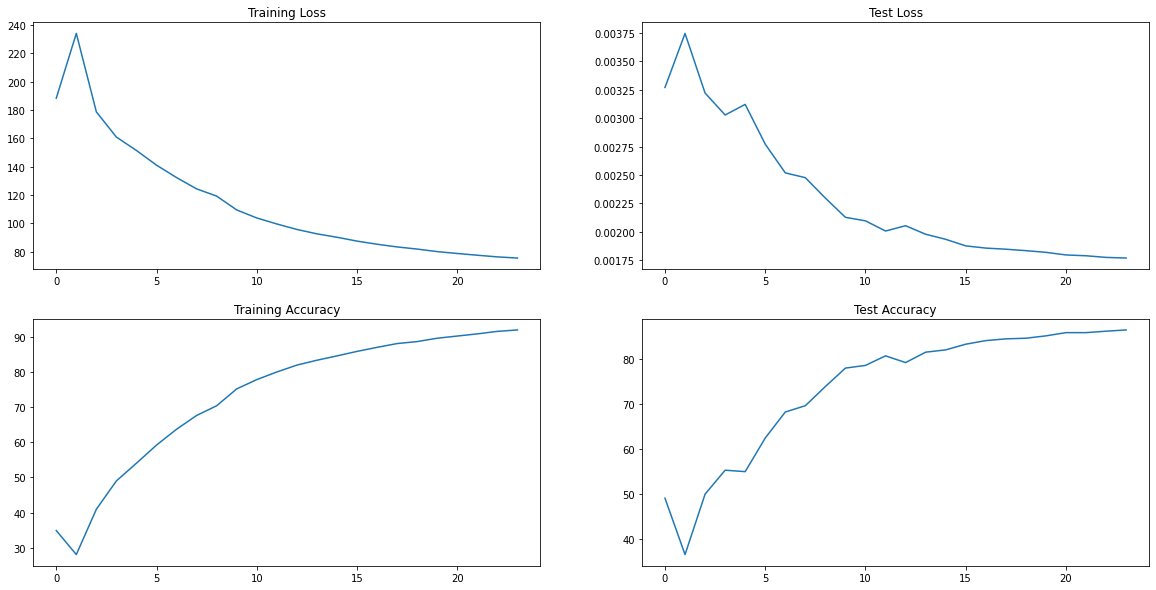

In [42]:
plot_graphs(train_losses=train_losses, train_accuracy=train_accuracy,
            test_losses=test_losses,test_accuracy=test_accuracy)    

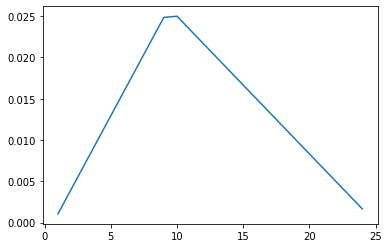

In [43]:
plt.plot(*zip(*lr_epochs))